In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
! pip install mpld3
import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
#функция, которая извлекает текст

def get_text(xml_file):
    with open(xml_file, 'rb') as f:
        xml = f.read()
        root = objectify.fromstring(xml)

        for cld in root.getchildren():
            for elem in cld.getchildren():
                for i in elem.getchildren():
                    text = str(i.text) 
    return text

In [5]:
os.chdir("D:\МОЯ ПАПКА\УЧЕБА\ВКР\corpus_ver2")

In [54]:
#обрабатываем тексты из xml-файлов, чтобы привести их в нужный формат

letters_texts = []
for i in os.listdir():
    letter = get_text(i)
    letter = re.sub(r'(\<(/?[^>]+)>)', ' ', letter)
    letter = re.sub('[^а-яА-Я ]', '', letter)
    letters_texts.append(letter)

print(len(letters_texts))
lettxt = open('letters_texts.txt', 'w', encoding='utf-8', errors='ignore')
lelcsv = open('letters_texts.csv', 'w', encoding='utf-8', errors='ignore')
for item in letters_texts:
    lettxt.write("%s\n" % item)
    lelcsv.write("%s\n" % item)
lettxt.close()
lelcsv.close()

3565


In [55]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

lemm_texts=[]

for i in letters_texts:
    h=i.split(' ')
    #print(h)
    s=''
    for k in h:
        p = morph.parse(k)[0].normal_form
        s+=' '
        s += p
    lemm_texts.append(s)
    
lemmtxt = open('lemm_texts.txt', 'w', encoding='utf-8', errors='ignore')
lemmcsv = open('lemm_texts.csv', 'w', encoding='utf-8', errors='ignore')
for item in lemm_texts:
    lemmtxt.write("%s\n" % item)
    lemmcsv.write("%s\n" % item)
lemmtxt.close()
lemmcsv.close()

In [7]:
with open ('lemm_texts.txt', encoding='utf-8') as f:
    lemm_texts = f.readlines()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 
train_data_features = vectorizer.fit_transform(lemm_texts)
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()

In [9]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def token_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#Создаем словари из полученных основ
totalvocab_stem = []
totalvocab_token = []
for i in lemm_texts:
    allwords_stemmed = token_and_stem(i)
    
    totalvocab_stem.extend(allwords_stemmed)
    
    allwords_tokenized = token_only(i)
    totalvocab_token.extend(allwords_tokenized)

In [11]:
stopwords = nltk.corpus.stopwords.words('russian')

stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на', 'и', 'о', 'есть', 'я', 'мой', 'вы', 'а', 'на',
                 'ваш', 'с', 'за', 'когда','тот', 'от', 'весь', 'по', 'такой'])

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_featur=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, tokenizer=token_and_stem, ngram_range=(1,3))

get_ipython().magic('time tfidf_matrix = tfidf_vectorizer.fit_transform(lemm_texts)')

print(tfidf_matrix.shape)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['бол', 'больш', 'будт', 'быт', 'ве', 'вед', 'впроч', 'всег', 'всегд', 'даж', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'чут', 'эт'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 1min 17s
(3565, 2151)


In [12]:
matrix = pd.DataFrame(tfidf_matrix)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

(3565, 3565)

In [14]:
num_clusters = 3

# Метод к-средних - KMeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
get_ipython().magic('time km.fit(tfidf_matrix)')
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

Wall time: 55.6 s


In [15]:
#k-means
clusterkm = km.labels_.tolist()

In [16]:
terms = tfidf_vectorizer.get_feature_names()
vocab_frame = pd.DataFrame({'слова': totalvocab_token}, index = totalvocab_stem)

In [17]:
from __future__ import print_function

print("Топ 10 термов в данном кластере:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Кластер %d. Слова :" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print()

Топ 10 термов в данном кластере:

Кластер 0. Слова :

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


 быть, это, письмо, писать, мой, вс, твой, получить, хороший, очень, весь, наш, ещ, свой, дорогой, написать, если, мочь, время, который,

Кластер 0. Запросы:Кластер 1. Слова : быть, наш, год, мой, весь, боев, свой, это, день, немец, война, который, дорогой, сын, родина, друг, часть, победа, вс, фронт,

Кластер 1. Запросы:Кластер 2. Слова : мама, письмо, привет, писать, живить, здоровый, пока, дорогой, мой, весь, быть, хороший, живить, получить, желать, свой, папа, сообщать, свидание, передавать,

Кластер 2. Запросы:

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

(3565, 3565)

In [19]:
# Метод главных компонент - PCA

from sklearn.decomposition import IncrementalPCA
icpa = IncrementalPCA(n_components=2, batch_size=16)
get_ipython().magic('time icpa.fit(dist) #demo =')
get_ipython().magic('time demo2 = icpa.transform(dist)')
xs, ys = demo2[:, 0], demo2[:, 1]

from sklearn.decomposition import IncrementalPCA
icpa = IncrementalPCA(n_components=3, batch_size=16)
get_ipython().magic('time icpa.fit(dist) #demo =')
get_ipython().magic('time ddd = icpa.transform(dist)')
xs, ys, zs = ddd[:, 0], ddd[:, 1], ddd[:, 2]

Wall time: 2.47 s
Wall time: 115 ms
Wall time: 2.02 s
Wall time: 108 ms


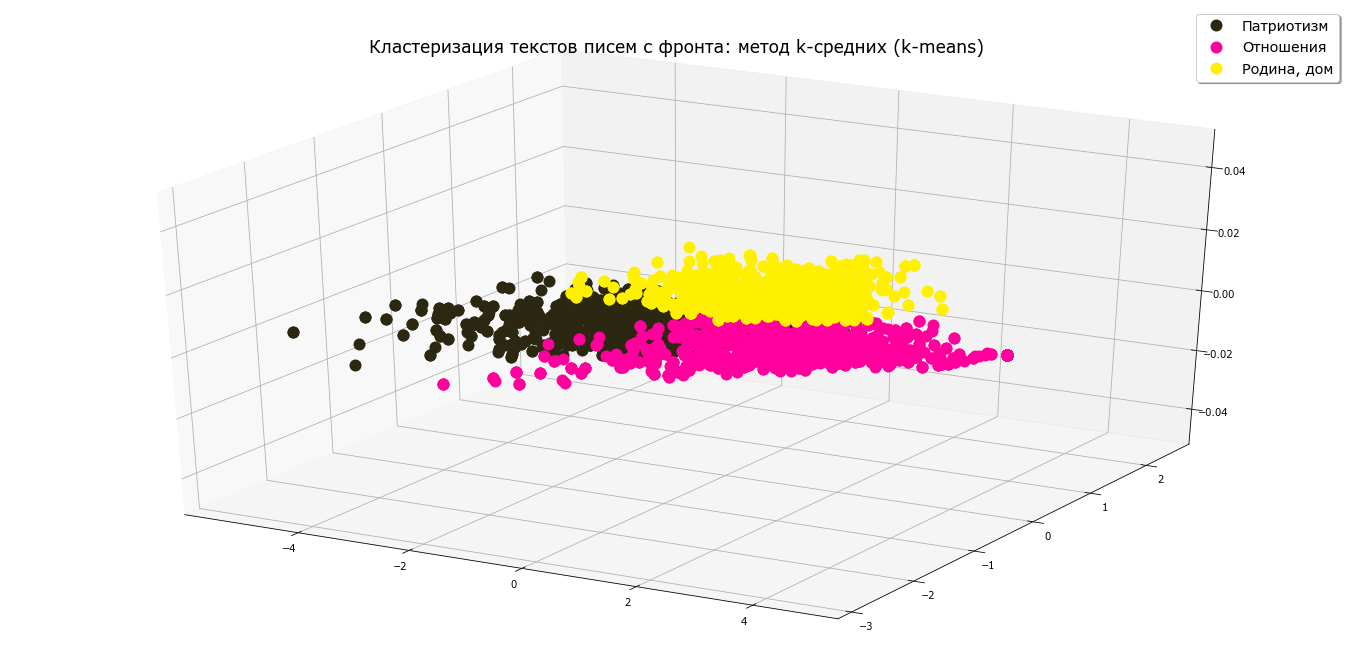

In [45]:
#Можно сразу примерно посмотреть, что получится в итоге
from mpl_toolkits.mplot3d import Axes3D

#включаем русские символы на графике
font = {'family' : 'Verdana'}#, 'weigth': 'normal'}
rc('font', **font)

#устанавливаем цвета
cluster_colors = {0: '#2b2711', 1: '#ff009d', 2: '#fff000'}

#даем имена кластерам
cluster_names = {0: 'Патриотизм',  1: 'Отношения', 2: 'Родина, дом'}
get_ipython().magic('matplotlib inline')

#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=xs, y=ys, label=clusterkm, title=lemm_texts)) 

#группируем по кластерам
groups = df.groupby('label')

fig = plt.figure(figsize=(24, 12))

ax = fig.add_subplot(111, projection='3d')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], 
            color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
    ax.tick_params(        axis= 'z',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
    
ax.legend(numpoints=1, loc='upper right', shadow=True, fontsize='x-large')  #показать легенду только 1 точки

plt.title('Кластеризация текстов писем с фронта: метод k-средних (k-means)', fontsize = 'xx-large')
plt.show()

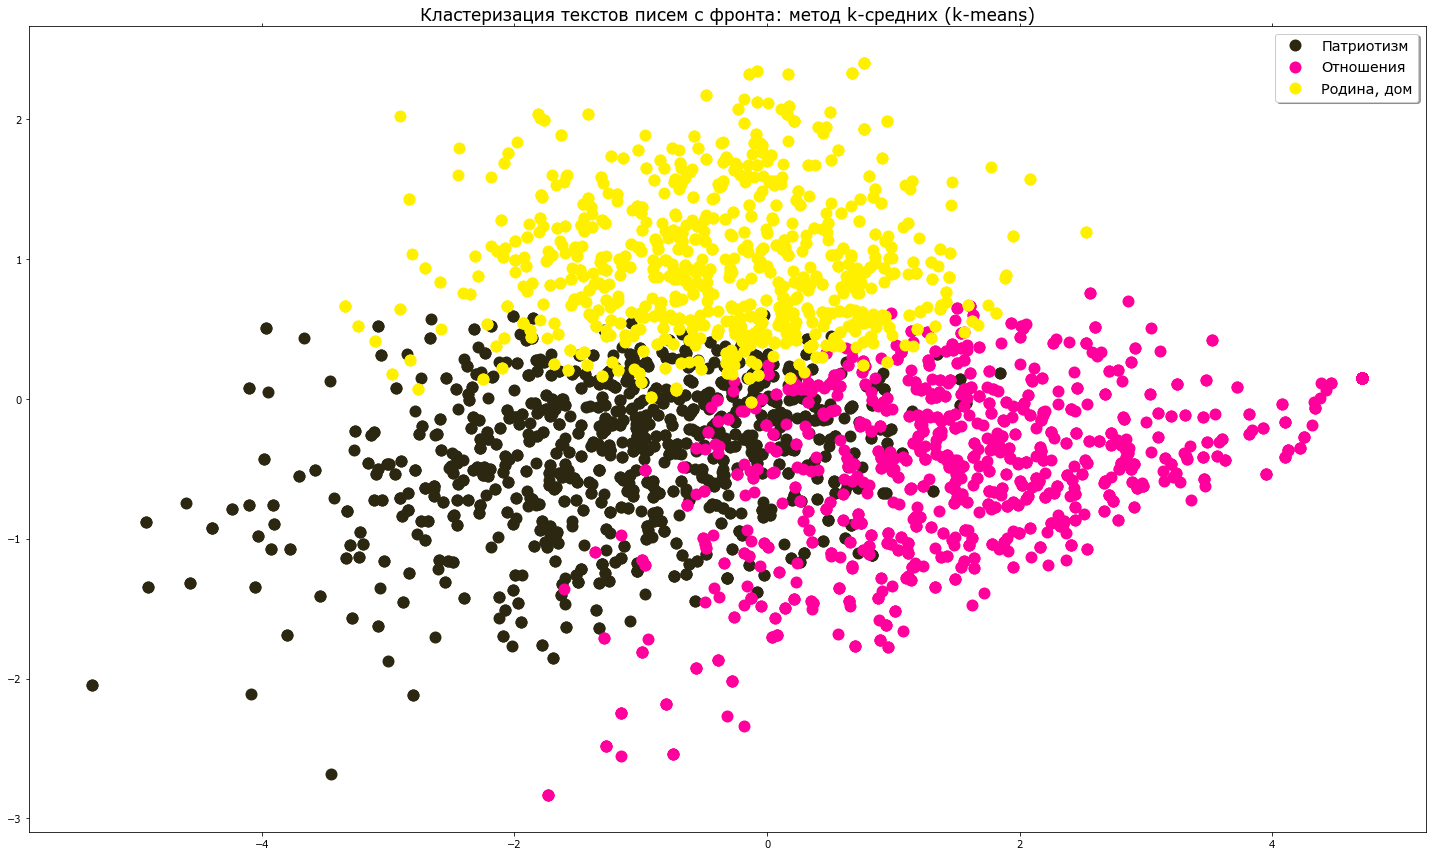

In [50]:
from matplotlib import rc
#включаем русские символы на графике
font = {'family' : 'Verdana'}#, 'weigth': 'normal'}
rc('font', **font)

#устанавливаем цвета
cluster_colors = {0: '#2b2711', 1: '#ff009d', 2: '#fff000'}

#даем имена кластерам,
cluster_names = {0: 'Патриотизм',  1: 'Отношения', 2: 'Родина, дом'}
get_ipython().magic('matplotlib inline')

#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=xs, y=ys, label=clusterkm, title=lemm_texts)) 

#группируем по кластерам
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 12)) #figsize подбирается под ваш вкус

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
    
ax.legend(numpoints=1, loc='upper right', shadow=True, fontsize='x-large')  #показать легенду только 1 точки

plt.title('Кластеризация текстов писем с фронта: метод k-средних (k-means)', fontsize = 'xx-large')

plt.tight_layout() 

#сохраним рисунок
plt.savefig('let_clust_kmean.png', dpi=200)
 

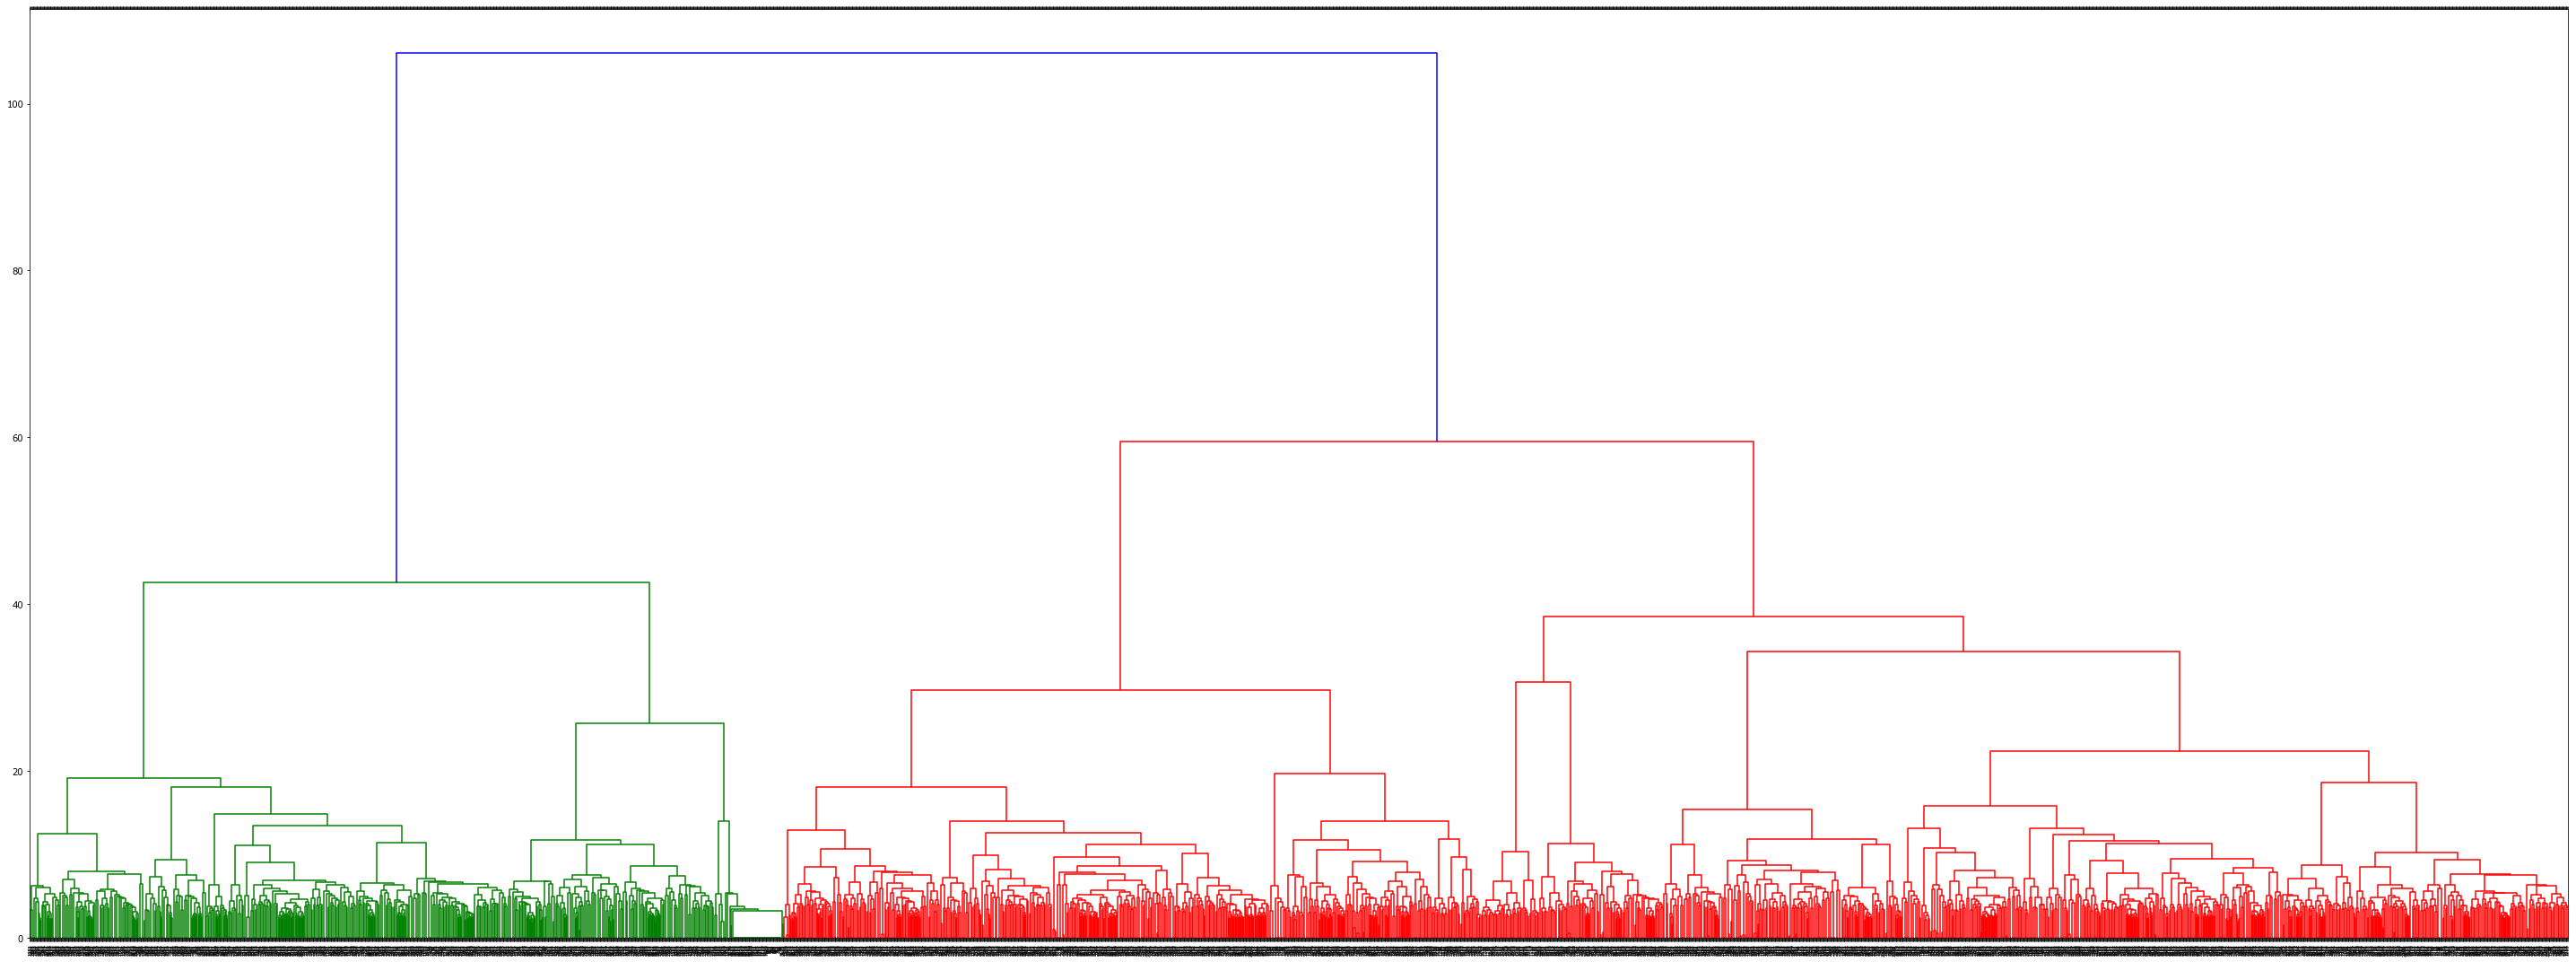

In [54]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(40, 15))
ax = dendrogram(linkage_matrix, orientation="top");

plt.tick_params(\
    axis= 'x',
    which='both', 
    bottom='off',
    top='off',
    labelbottom='off')

plt.tight_layout() 

#сохраним рисунок
plt.savefig('ward_clusters2.png', dpi=200)